In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
df = pd.read_csv('customer_conversations_analysis.csv')

In [3]:
df

,customer_text,agent_text,transcript_file,sentiment,outcome
0,"Hi, I'm calling to get a case pre-authorized. ...","Hi Emily, thank you for calling PA customer ...",transcript_0.txt,Neutral,Issue Resolved
1,"Hi, I'm calling about a denied claim I receive...","I apologize for the inconvenience, MEM123456...",transcript_1.txt,Negative,Follow-up Needed
2,"Hi, I'm calling to schedule an appointment wit...","Hi Emily, thank you for calling. Can you ple...",transcript_10.txt,Positive,Issue Resolved
3,"Hi, I'm calling about a denied claim I receive...","I apologize for the inconvenience, MEM123456...",transcript_100.txt,Negative,Follow-up Needed
4,"Hi, I'm calling to schedule an appointment wit...","Hi Emily, thank you for reaching out. Can yo...",transcript_101.txt,Positive,Issue Resolved
...,...,...,...,...,...
195,"Hi, I'm having some trouble registering and lo...","I'd be happy to help you with that, MEM12345...",transcript_95.txt,Positive,Issue Resolved
196,"Hi, I'm calling about a denied claim. My claim...","I apologize for the inconvenience, MEM123456. ...",transcript_96.txt,Neutral,Follow-up Needed
197,"Hi, I'm having trouble registering and logging...","I'd be happy to help you, MEM123456. Can you...",transcript_97.txt,Positive,Issue Resolved
198,"Hi, I'm calling about a denied claim I receive...","I apologize for the inconvenience, MEM123456. ...",transcript_98.txt,Positive,Issue Resolved


In [8]:
df.sentiment.value_counts()

sentiment
Positive    110
Neutral      61
Negative     29
Name: count, dtype: int64

In [7]:
df.sentiment.value_counts(normalize=True)

sentiment
Positive    0.550
Neutral     0.305
Negative    0.145
Name: proportion, dtype: float64

In [9]:
df.outcome.value_counts()

outcome
Issue Resolved      134
Follow-up Needed     66
Name: count, dtype: int64

In [10]:
df.outcome.value_counts(normalize = True)

outcome
Issue Resolved      0.67
Follow-up Needed    0.33
Name: proportion, dtype: float64

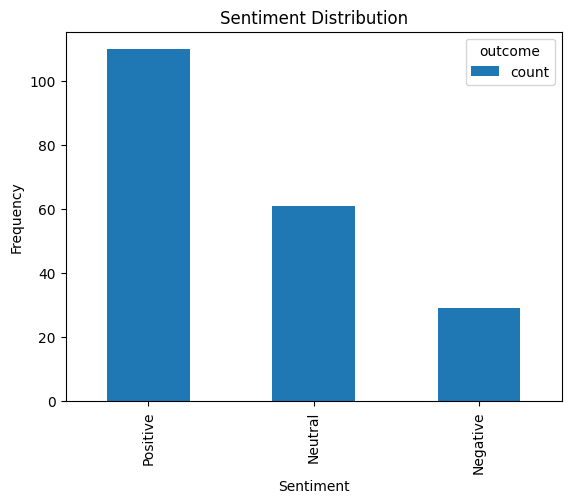

In [33]:
df['sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

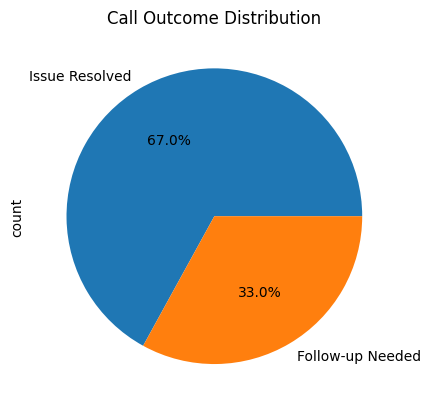

In [19]:
df['outcome'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Call Outcome Distribution')
plt.show()

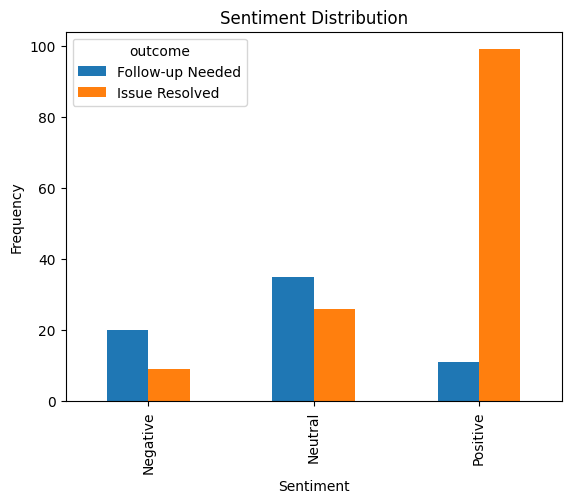

In [34]:
sentiment_outcome_distribution = df.groupby(['sentiment','outcome']).size().unstack(fill_value = 0)
sentiment_outcome_distribution.plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.legend(title = 'outcome')
plt.show()

In [29]:
negative_text_lst = df.loc[df.sentiment == 'Negative','customer_text']
negative_texts = ' '.join(negative_text_lst)
print(negative_texts)

Hi, I'm calling about a denied claim I received for my recent medical service. I was told that my policy doesn't cover it, but I'm certain it should be covered under my new policy. My member ID is MEM123456. The claim number is CLM789012, and the date of service was February 10th. I switched policies on January 1st. I was told that the new policy would cover the service I received, but the denial letter says it's not covered. That's frustrating. How can we get this resolved? No, that's all. Thank you for your help. Thank you. Hi, I'm calling about a denied claim I received for a recent medical service. I believe it was denied in error. Hi, I'm having trouble registering and logging in to my online service account. My member ID is MEM123456. Well, I'm trying to register for the first time, but it keeps saying that my member ID is invalid. I've double-checked that I've entered it correctly. Yes, that's exactly what I'm doing. It's MEM123456. I haven't set up a password yet, I'm trying to

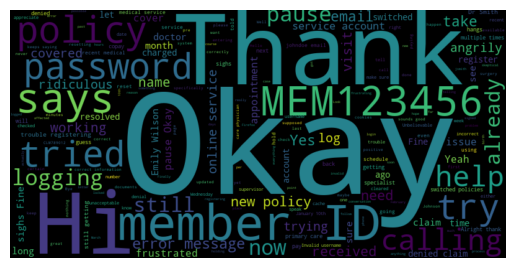

In [30]:
wordcloud = WordCloud(width=800, height=400).generate(negative_texts)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Deep Analysis of Issues with Negative Sentiment

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
negative_conversations_vectorized = vectorizer.fit_transform(negative_text_lst)

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(negative_conversations_vectorized)

# Display the top words in each topic
feature_names = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx + 1}:")
    print([feature_names[i] for i in topic.argsort()[-10:]])
    print()

Topic 1:
['logging', 'account', 'email', 'thank', 'try', 'password', 'tried', 'pause', 've', 'okay']

Topic 2:
['primary', 'pay', 'ridiculous', 'doctor', '50', 'charged', 'shouldn', 'says', 'policy', 'visit']

Topic 3:
['know', 'thank', 'medical', 'service', 'hi', 'calling', 'told', 'recent', 'denied', 'supposed']

Topic 4:
['id', 'mem123456', 'hi', 'switched', 'new', 'claim', 'okay', 'service', 'thank', 'policy']

Topic 5:
['received', 'bye', 'thanks', 'checked', 'good', 'sure', 'pause', 'got', 'email', 'information']



In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import openai


# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
negative_conversations_vectorized = vectorizer.fit_transform(negative_text_lst)

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(negative_conversations_vectorized)

# Extract feature names
feature_names = vectorizer.get_feature_names_out()

# Function to generate a topic name using GPT
def summarize_topic_gpt(top_words):
    prompt = f"Summarize the following list of words into a concise topic name for better categorisation of the issues: {', '.join(top_words)}."
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[{"role": "user", "content": prompt}]
    )
    return response['choices'][0]['message']['content'].strip()

# Iterate through the topics and generate names using GPT
topic_names = {}
for idx, topic in enumerate(lda.components_):
    # Get the top 10 words for each topic
    top_words = [feature_names[i] for i in topic.argsort()[-10:]]
    # Use GPT to generate a name for the topic
    topic_name = summarize_topic_gpt(top_words)
    topic_names[f"Topic {idx + 1}"] = topic_name
    print(f"Topic {idx + 1}: {topic_name}")
    print(f"Top words: {', '.join(top_words)}")
    print()

Topic 1: "Account and Email Management Issues"
Top words: logging, account, email, thank, try, password, tried, pause, ve, okay

Topic 2: "Dispute over High Charges for Primary Doctor Visits"
Top words: primary, pay, ridiculous, doctor, 50, charged, shouldn, says, policy, visit

Topic 3: "Customer Service Issues in Medical Sector"
Top words: know, thank, medical, service, hi, calling, told, recent, denied, supposed

Topic 4: "Policy Change and Claim Service Communications"
Top words: id, mem123456, hi, switched, new, claim, okay, service, thank, policy

Topic 5: "Communication and Acknowledgement"
Top words: received, bye, thanks, checked, good, sure, pause, got, email, information



In [38]:
from sklearn.model_selection import train_test_split
test_size = 0.1
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(df,y,test_size=test_size,stratify=y, random_state=42)

In [40]:
X_test

,customer_text,agent_text,transcript_file,sentiment,outcome
55,"Hi, I'm calling about my recent doctor's visit...",I'd be happy to help you with that. Can you ...,transcript_148.txt,Neutral,Follow-up Needed
106,"Hi, I'm calling about a claim that was denied....","I apologize for the inconvenience, Mr...? ...",transcript_194.txt,Positive,Issue Resolved
100,"Hi, I'm having trouble registering and logging...",Sorry to hear that you're having trouble. Can ...,transcript_189.txt,Neutral,Follow-up Needed
78,"Hi, I'm calling about a denied claim I receive...","Thank you for reaching out, Emily. I'd be ha...",transcript_169.txt,Positive,Issue Resolved
197,"Hi, I'm having trouble registering and logging...","I'd be happy to help you, MEM123456. Can you...",transcript_97.txt,Positive,Issue Resolved
105,"Hi, I'm calling about a denied claim I receive...","I apologize for the inconvenience, Mr... (pa...",transcript_193.txt,Neutral,Issue Resolved
18,"Hi, I'm calling to schedule an appointment wit...","Hi Emily, thank you for calling. Can you ple...",transcript_114.txt,Positive,Issue Resolved
57,"Hi, I'm calling to request a case pre-authoriz...","Thank you for calling PA customer care, Emil...",transcript_15.txt,Positive,Issue Resolved
152,"Hi, I'm calling to get a case pre-authorized. ...","Thank you for calling PA customer care, Emil...",transcript_56.txt,Positive,Follow-up Needed
123,"Hi, I'm calling about my recent visit to the d...","I apologize for the inconvenience, can you p...",transcript_3.txt,Negative,Follow-up Needed


In [41]:
X_test.to_csv('test_data.csv')

In [42]:
x_test_result = pd.read_csv('test_data.csv')
x_test_result

,customer_text,agent_text,transcript_file,sentiment,outcome,y_sentiment,y_outcome
0,"Hi, I'm calling about my recent doctor's visit...",I'd be happy to help you with that. Can you ...,transcript_148.txt,Neutral,Follow-up Needed,Neutral,Follow-up Needed
1,"Hi, I'm calling about a claim that was denied....","I apologize for the inconvenience, Mr...? ...",transcript_194.txt,Positive,Issue Resolved,Neutral,Follow-up Needed
2,"Hi, I'm having trouble registering and logging...",Sorry to hear that you're having trouble. Can ...,transcript_189.txt,Neutral,Follow-up Needed,Neutral,Follow-up Needed
3,"Hi, I'm calling about a denied claim I receive...","Thank you for reaching out, Emily. I'd be ha...",transcript_169.txt,Positive,Issue Resolved,Positive,Issue Resolved
4,"Hi, I'm having trouble registering and logging...","I'd be happy to help you, MEM123456. Can you...",transcript_97.txt,Positive,Issue Resolved,Positive,Issue Resolved
5,"Hi, I'm calling about a denied claim I receive...","I apologize for the inconvenience, Mr... (pa...",transcript_193.txt,Neutral,Issue Resolved,Neutral,Follow-up Needed
6,"Hi, I'm calling to schedule an appointment wit...","Hi Emily, thank you for calling. Can you ple...",transcript_114.txt,Positive,Issue Resolved,Positive,Issue Resolved
7,"Hi, I'm calling to request a case pre-authoriz...","Thank you for calling PA customer care, Emil...",transcript_15.txt,Positive,Issue Resolved,Positive,Issue Resolved
8,"Hi, I'm calling to get a case pre-authorized. ...","Thank you for calling PA customer care, Emil...",transcript_56.txt,Positive,Follow-up Needed,Positive,Follow-up Needed
9,"Hi, I'm calling about my recent visit to the d...","I apologize for the inconvenience, can you p...",transcript_3.txt,Negative,Follow-up Needed,Negative,Follow-up Needed


In [43]:
sentiment_match = x_test_result.sentiment == x_test_result.y_sentiment
sentiment_accuracy = sentiment_match.sum()/len(x_test_result) * 100

In [44]:
sentiment_accuracy

np.float64(80.0)

In [47]:
outcome_match = x_test_result.outcome == x_test_result.y_outcome
outcome_accuracy = outcome_match.sum()/len(x_test_result) * 100

In [49]:
outcome_accuracy

np.float64(80.0)